In [42]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [63]:
# how many characters to take to make prediction
block_size = 3
X, Y = [], []

# build trigram training set
for w in words[:5]:
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
    
X = torch.tensor(X)
Y = torch.tensor(Y)

In [64]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

## Build embeding lookup table C

In [65]:
C = torch.randn((27, 2))

Indexing into C:

In [66]:
C[5]

tensor([0.6976, 1.6100])

In [67]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

## Implementing Hidden Layer

In [68]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

Using `torch.cat` to concat embedings into 32x6 size

In [69]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[: ,2, :]], 1).shape

torch.Size([32, 6])

In [70]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

We can represent any tensor as any sized tensor since it's stored as a vector

In [71]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [72]:
a.shape

torch.Size([18])

In [73]:
a.view(9, 2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [74]:
a.view(3,3,2).shape

torch.Size([3, 3, 2])

In [76]:
emb.view(32, 6).shape

torch.Size([32, 6])

*`emb.view(-1 ,6)` infers the size of `emb` instead of hardcoding `32`.*

Thus hidden layer is following:

In [118]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h

tensor([[-0.9932,  1.0000,  0.9707,  ...,  0.9844,  1.0000,  0.7849],
        [-0.8994,  0.9988, -0.9893,  ...,  0.9939, -0.9990,  0.9927],
        [-0.9092,  1.0000,  0.9883,  ...,  0.9440,  0.0186,  1.0000],
        ...,
        [-0.2630,  0.9998,  0.8147,  ...,  0.9728,  0.9243,  1.0000],
        [-0.9788,  1.0000,  0.9960,  ...,  0.5332,  0.9648,  1.0000],
        [-0.2630,  0.9998,  0.8147,  ...,  0.9728,  0.9243,  1.0000]],
       grad_fn=<TanhBackward0>)

## The Output Layer

In [119]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [120]:
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

In [121]:
prob.shape

torch.Size([32, 27])

In [122]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(19.7385, grad_fn=<NegBackward0>)

### Putting Together

In [123]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [124]:
sum(p.nelement() for p in parameters)

3481

## Training

In [125]:
for p in parameters:
  p.requires_grad = True

In [126]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [127]:
lri = []
lossi = []

for i in range(10000):
  # minibatch construction
  ix = torch.randint(0, X.shape[0], (32,))
  
  # Forward pass
  emb = C[X[ix]]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix])
  #print(loss.item())

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad
    
  # track
  #lri.append(lre[i])
  #lossi.append(loss.item())
    
print(loss.item())

0.27182888984680176


We can introduce batching to not to iterate over all the examples every time. Iterate over small batch and move to another.

The quality of gradient is lower that way. So the direction is not reliable but good enough. It's better to have approx direction and take more steps than trying to get more precise graient with fewer steps.

In [99]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.7486, grad_fn=<NllLossBackward0>)

## Learning Rate

How can we determine the learning speed (`+= -0.1`)?

In [116]:
# Learning Rate Exponent
lre = torch.linspace(0.001, 1, 1000)
lrs = 10**lre

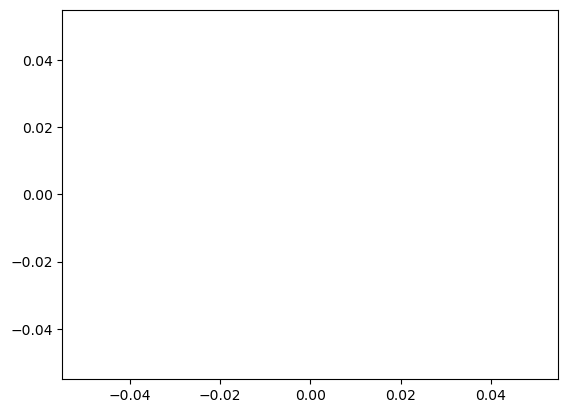

In [117]:
plt.plot(lri, lossi)

## Dataset Splits

In [100]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [101]:
n1

25626

In [102]:
n2

28829

In [103]:
n2 - n1 # dev examples

3203

In [104]:
len(words) - n2 # test examples

3204

## Update Training and Evaluation With Splits

In [168]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [169]:
sum(p.nelement() for p in parameters)

11897

In [170]:
for p in parameters:
  p.requires_grad = True

In [171]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

Train on "train" dataset

In [172]:
lri = []
lossi = []
stepi = []

In [185]:
for i in range(200000):
  # minibatch construction
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # Forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 1000000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
    
  # track
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())
    
#print(loss.item())

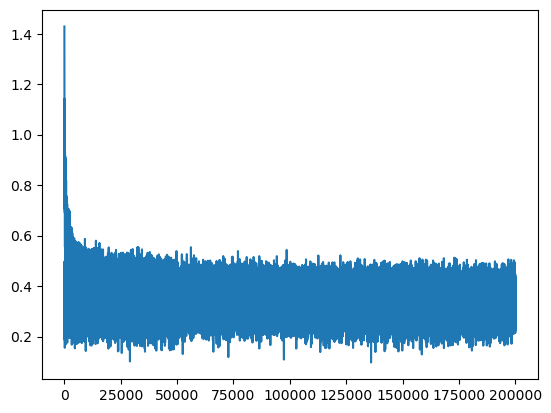

In [186]:
plt.plot(stepi, lossi)

Evaluate on "dev" dataset

Train and dev loss should be ~equal (underfitting) at first

In [187]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2377, grad_fn=<NllLossBackward0>)

In [188]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2985, grad_fn=<NllLossBackward0>)

To scale we bump neurons in hidden layer from 100 to 300 ☝🏻

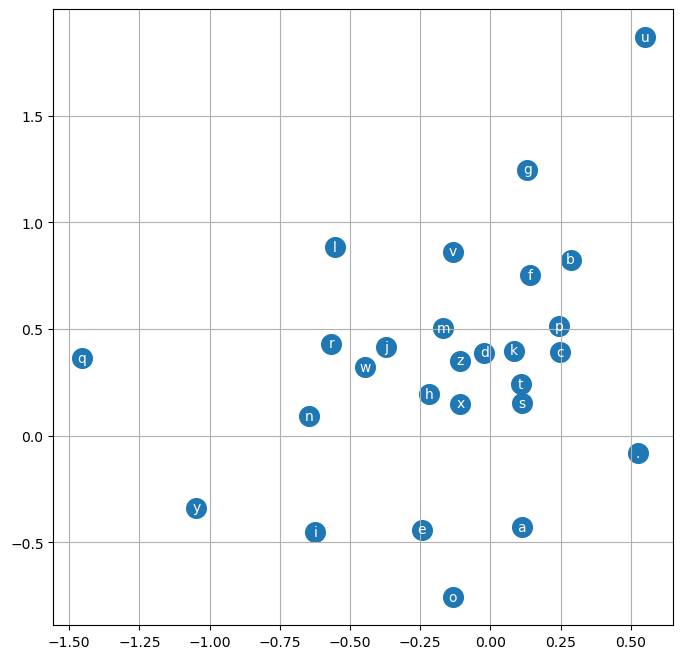

In [158]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

Now we scale embeddings from 2 to 10 dimensions and decrease number of neurons to 200

## How to Sample

In [189]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [190]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

morahmayah.
deen.
ndhayah.
remmani.
jernegradelyn.
eliah.
milah.
reden.
carlear.
emyziah.
karin.
shrancishirael.
jonie.
jenslen.
priyan.
zaredaryandreyah.
yumajaysen.
daihaan.
adyansyn.
zarelle.
